#### Feature Engineering & Encoding.

Esto lo ponemos en un notebook aparte porque a partir de acá se crearán Pipelines para los datos, además, se crearán los artifacts necesarios a usar en el despliegue.

**Feature Engineering tasks:** 

- Geohashes. **DONE**
- Spatial Feature Engineering
- Diferencia y proporción entre area total y area construida. **DONE**
- Qué tanto difiere el tamaño de casa con el promedio del distrito.  **DONE**

**Hacer encodings**

**Ver Correlaciones**

**Ver distribuciones por categorías**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geohash2 as gh #pip install geohash2
import gc

lima_data = pd.read_csv('../data/2020_Notebook01_clean_data.csv')
lima_data.describe()

#Las coordenadas son negativas, se scrapearon sin el -1
lima_data['latitud'] = lima_data['latitud']*-1
lima_data['longitud'] = lima_data['longitud']*-1

#### Feature Engineering

In [2]:
lima_data['areas_diff'] = lima_data['Area_total'] - lima_data['Area_constr']

In [3]:
lima_data['areas_proporcion'] = lima_data['Area_total']/lima_data['Area_constr']

In [4]:
drop_prop = lima_data[lima_data['areas_proporcion'] >= 4.0].index
lima_data.drop(drop_prop, inplace=True)

In [27]:
#Esto como proxy para detectar outliers (que aun existen)
tmp_table = lima_data.groupby('Barrio', as_index=False)['Area_total'].mean()
tmp_table = pd.merge(tmp_table, lima_data, on=['Barrio'], how='inner', suffixes=('_TMP','_ORIGIN'))
lima_data['diff_total_mean_district'] = tmp_table['Area_total_ORIGIN'] - tmp_table['Area_total_TMP']

In [31]:
lima_data.describe()

,latitud,longitud,Precio,Area_total,Area_constr,Precio_m2_total,Precio_m2_constr,Area_constr_cat,NroBanios,Dormitorios,Antiguedad,Cocheras,areas_diff,areas_proporcion,diff_total_mean_district
count,5231.000000,5231.000000,5.231000e+03,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5076.000000
mean,-12.131348,-76.952278,2.652624e+06,474.113554,341.923724,6117.251223,7399.449532,9.663735,3.661250,4.410820,24.255783,2.672338,132.189830,1.352777,-0.262416
std,0.618621,0.445843,2.038581e+06,367.149884,165.449486,3518.636205,3876.101999,5.692226,0.967911,1.135062,9.977640,1.071479,279.731276,0.662417,318.714318
min,-53.163383,-79.221148,6.800000e+04,40.000000,31.000000,21.200000,23.555556,0.000000,1.000000,1.000000,1.000000,1.000000,-520.000000,0.171875,-629.233466
25%,-12.119827,-77.020543,1.225000e+06,238.000000,224.000000,3937.500000,5026.620224,5.000000,3.000000,4.000000,17.000000,2.000000,0.000000,1.000000,-181.273584
50%,-12.092327,-76.975682,2.158000e+06,340.000000,318.000000,5569.892473,6796.988270,10.000000,4.000000,4.000000,22.000000,2.000000,1.000000,1.003571,-56.428125
75%,-12.077283,-76.926842,3.430000e+06,595.000000,421.000000,7328.070476,8955.208128,14.000000,4.000000,5.000000,30.000000,3.000000,175.000000,1.581818,104.611538
max,-7.888933,-47.920490,1.225000e+07,2657.000000,1010.000000,55168.035000,81065.573770,19.000000,20.000000,20.000000,65.000000,6.000000,1937.000000,3.975000,2184.611538


#### GeoHashes

In [6]:
for num in range(5, 10):
    lima_data['geohash_grado{}'.format(num)] = lima_data.apply(lambda x: gh.encode(x['latitud'], x['longitud'], precision = num),axis=1)

In [7]:
top_geohashes = lima_data['geohash_grado7'].value_counts().iloc[0:7].keys().tolist()

#En qué Distrito están los barrios con mayor oferta?
lima_data[lima_data['geohash_grado7'].isin(top_geohashes)]['Barrio'].value_counts()

La Molina            242
Santiago de Surco     30
San Isidro            27
Miraflores             8
NoEspecifica           6
San Borja              1
Barranco               1
Lima Cercado           1
La Victoria            1
Ate Vitarte            1
Name: Barrio, dtype: int64

#### OJO! Varios anuncios no ponen las coordenadas exactas, sino unas aledañas. Por eso se ve como si este barrio tuviera varias casas en oferta. Son las mismas 78 coordenadas. Pero diferentes casas. En la Molina toman de referencia el Molicentro. Igual pasa en Surco y en San isidro pero con algo de menos frecuencia. 

In [8]:
lima_data[lima_data['geohash_grado7'] == top_geohashes[0]][['latitud','longitud']].value_counts()

latitud     longitud  
-12.082020  -76.928234    77
-12.081859  -76.928393     2
            -76.928393     2
-12.082020  -76.928234     2
-12.081075  -76.928427     1
-12.081714  -76.927820     1
-12.081852  -76.928062     1
-12.082040  -76.928287     1
dtype: int64

In [9]:
print(lima_data[lima_data['geohash_grado7'] == top_geohashes[1]][['latitud','longitud']].value_counts())
print(lima_data[lima_data['geohash_grado7'] == top_geohashes[2]][['latitud','longitud']].value_counts())

latitud     longitud  
-12.096333  -77.028072    84
dtype: int64
latitud     longitud  
-12.081241  -76.899002    29
            -76.899002     3
-12.081205  -76.899319     1
-12.081232  -76.898994     1
-12.081352  -76.899297     1
dtype: int64


In [10]:
lima_data.filter(regex='^(geohash*)').describe()    

,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9
count,5231,5231,5231,5231,5231
unique,118,729,2711,3665,3786
top,6mc5p,6mc732,6mc732w,6mc5pjvv,6mc5pjvvg
freq,728,136,87,84,84


#### Correlaciones

<AxesSubplot:>

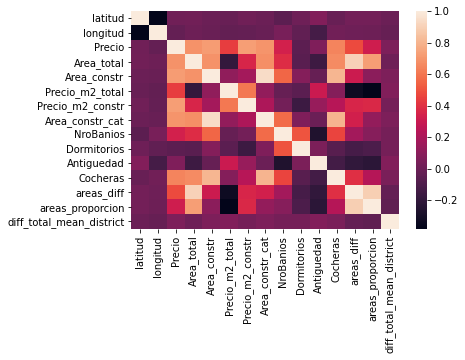

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = lima_data.corr()
sns.heatmap(corr)
#Las cocheras están correlacionadas con el Precio???

##### Selección del Target.

Tenemos 4 formas de target:

- Precio: Precio total del inmueble.

- Precio_m2_total: Precio / metros cuadrados del area total.

- Precio_m2_constr: Precio / metros cuadrados del area construida.

- Precio_cat: Precio por categorias.

In [35]:
X = lima_data.drop(lima_data.filter(regex='(P?p?recio)').columns,axis=1)
Y = lima_data.filter(regex='(P?p?recio)')
print('columnas Y: {}'.format(Y.columns.values))

columnas Y: ['Precio' 'Precio_m2_total' 'Precio_m2_constr' 'Precio_cat']


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y['Precio_m2_total'], test_size=0.1, random_state = 215)

In [37]:
pd.concat([X_train,y_train],axis=1).to_csv('../data/2020_Notebook02_train_output.csv',index=False)

pd.concat([X_test,y_test],axis=1).to_csv('../data/2020_Notebook02_test_output.csv',index=False)